In [1]:
import sys
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Mar 29 2018, 13:14:23) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on October 14 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu
"""

'\nCreated on October 14 2018\n@author: Neven Caplar\n@contact: ncaplar@princeton.edu\n'

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 16})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances

DATA_DIRECTORY='/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/'

In [6]:
np.__version__

'1.15.4'

# Preparation of sql query

In [12]:
# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html

dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, header=None )
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])

Skipping line 305: Expected 75 fields in line 305, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1633: Expected 75 fields in line 1633, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1745: Expected 75 fields in line 1745, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1828: Expected 75 fields in line 1828, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 3631: Expected 75 fields in line 3631, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4123: Expected 75 fields in line 4123, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4124: Expected 75 fields in line 4124, saw 76. Error could possibly be due to quotes bei

In [13]:
#extract ra and dec values for SQL query

data = np.zeros(len(Positions_of_dr7), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

data['ra'] = Positions_of_dr7[:,0]
data['dec'] =  Positions_of_dr7[:,1]

PositionOfQuasars=data

np.save(DATA_DIRECTORY+'PositionOfQuasars',PositionOfQuasars)

In [14]:
PositionOfQuasar=np.load(DATA_DIRECTORY+'PositionOfQuasars.npy')

In [89]:
#############################
# This is how to find create values to be feed to SQL query system for HSC
# This query creates the table that we import in the analysis part below (so it can be skipped if you just want to just analyze result of this query).
# In terminal run command seen below - this is code which I modified from https://hsc-gitlab.mtk.nao.ac.jp/snippets/13
# Run the command in Python 2!!!
# the part in the command below that says <--columns ["g_cmodel_mag","g_cmodel_mag"]> does not mean I am just taking g_cmodel magnitude - I needed something as a filler

# run 'python CatalogCreator.py PositionOfQuasars.npy --columns ["g_cmodel_mag","g_cmodel_mag"]'

#############################

In [ ]:
# This is example of the SQL query to find the data
# Copy paste result from the CatalogCreator.py (also avaliable on github) command into VALUES() bracket, make sure VALUES() is in only one line, and run query at https://hscdata.mtk.nao.ac.jp:4443/datasearch/
# This run took around 3 hours

'''
WITH
    user_catalog("user.ra","user.dec") AS (VALUES('2.7227999642500000e-02'::double precision,'5.1534098386799998e-01'::double precision),('3.3900000154999999e-02','2.7630099654200002e-01'),('3.8603998720599997e-02','1.5298477172900000e+01'),('3.9089001715200002e-02','1.3938449859600000e+01'),('3.9271000772700002e-02','-1.0464426040599999e+01'),('4.7548998147199997e-02','1.4929354667700000e+01'),('4.9839001148899997e-02','4.0364999324100002e-02'),('5.1079001277700001e-02','-5.3904700279200002e-01'),('5.4786998778600000e-02','1.4176302909900000e+01'),('5.7505998760499999e-02','-9.1300100088100000e-01'))
    ,
    match AS (
        SELECT
            object_id,
            earth_distance(coord, ll_to_earth("user.dec", "user.ra")) AS match_distance,
            user_catalog.*
        FROM
            user_catalog JOIN s18a_wide.forced
                ON coneSearch(coord, "user.ra", "user.dec", 0.1) 
    )
SELECT
	f.ra,
	f.dec,
	f.g_cmodel_mag,
	f.g_cmodel_magsigma,
	f.r_cmodel_mag,
	f.r_cmodel_magsigma,
	f.i_cmodel_mag,
	f.i_cmodel_magsigma,
    f2.g_psfflux_mag,
    f2.g_psfflux_magsigma,
    f2.r_psfflux_mag,
    f2.r_psfflux_magsigma,
    f2.i_psfflux_mag,
    f2.i_psfflux_magsigma,
    f.object_id
FROM
    match LEFT JOIN s18a_wide.forced AS f USING(object_id)
JOIN s18a_wide.forced2 AS f2 ON f.object_id = f2.object_id
WHERE
    f.isprimary
'''

In [ ]:
# This is the example of the SQL query to find the data, as ran on the server on February 8, 2019
# Added quality flags from Yusra AlSayyad
# Copy paste result from the CatalogCreator.py (also avaliable on github) command into VALUES() bracket, make sure VALUES() is in only one line, and run query at https://hscdata.mtk.nao.ac.jp:4443/datasearch/
# This run took around 3 hours

'''
WITH
    user_catalog("user.ra","user.dec") AS (VALUES('2.7227999642500000e-02'::double precision,'5.1534098386799998e-01'::double precision),('3.3900000154999999e-02','2.7630099654200002e-01'),('3.8603998720599997e-02','1.5298477172900000e+01'),('3.9089001715200002e-02','1.3938449859600000e+01'),('3.9271000772700002e-02','-1.0464426040599999e+01'),('4.7548998147199997e-02','1.4929354667700000e+01'),('4.9839001148899997e-02','4.0364999324100002e-02'),('5.1079001277700001e-02','-5.3904700279200002e-01'),('5.4786998778600000e-02','1.4176302909900000e+01'),('5.7505998760499999e-02','-9.1300100088100000e-01'))
    ,
    match AS (
        SELECT
            object_id,
            earth_distance(coord, ll_to_earth("user.dec", "user.ra")) AS match_distance,
            user_catalog.*
        FROM
            user_catalog JOIN s18a_wide.forced
                ON coneSearch(coord, "user.ra", "user.dec", 0.1) 
    )
SELECT
	f.ra,
	f.dec,
	f.g_cmodel_mag,
	f.g_cmodel_magsigma,
	f.r_cmodel_mag,
	f.r_cmodel_magsigma,
	f.i_cmodel_mag,
	f.i_cmodel_magsigma,
    f2.g_psfflux_mag,
    f2.g_psfflux_magsigma,
    f2.r_psfflux_mag,
    f2.r_psfflux_magsigma,
    f2.i_psfflux_mag,
    f2.i_psfflux_magsigma,
    f.object_id
FROM
    match LEFT JOIN s18a_wide.forced AS f USING(object_id)
JOIN s18a_wide.forced2 AS f2 ON f.object_id = f2.object_id
WHERE
    f.isprimary
    AND NOT f.g_psfflux_flag
    AND NOT f.r_psfflux_flag
    AND NOT f.i_psfflux_flag
    AND NOT f.g_cmodel_flag 
    AND NOT f.r_cmodel_flag
    AND NOT f.i_cmodel_flag
    AND NOT f.g_pixelflags_edg
    AND NOT f.r_pixelflags_edge
    AND NOT f.i_pixelflags_edge        
    AND NOT f.g_pixelflags_bad 
    AND NOT f.r_pixelflags_bad
    AND NOT f.i_pixelflags_bad
    AND NOT f.g_pixelflags_interpolatedcenter
    AND NOT f.r_pixelflags_interpolatedcenter
    AND NOT f.i_pixelflags_interpolatedcenter
    AND NOT f.g_pixelflags_saturatedcenter 
    AND NOT f.r_pixelflags_saturatedcenter
    AND NOT f.i_pixelflags_saturatedcenter
    AND NOT f.g_pixelflags_crcenter
    AND NOT f.r_pixelflags_crcenter
    AND NOT f.i_pixelflags_crcenter
'''

# Analysis of the output

## Initial Analysis

In [7]:
# This is dr7 qso catalog from https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html
dr7 = pd.read_csv(DATA_DIRECTORY+'dr7qso.dat',skiprows=80,sep='\s+',engine='python', error_bad_lines=False, header=None )
Positions_of_dr7=np.transpose([dr7[1].values,dr7[2].values])

Skipping line 305: Expected 75 fields in line 305, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1633: Expected 75 fields in line 1633, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1745: Expected 75 fields in line 1745, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1828: Expected 75 fields in line 1828, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 3631: Expected 75 fields in line 3631, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4123: Expected 75 fields in line 4123, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4124: Expected 75 fields in line 4124, saw 76. Error could possibly be due to quotes bei

In [ ]:
134504.64-005608.7

In [173]:
dr7.loc[71051]

0      134504.64-005608.7
1                 206.269
2               -0.935759
3                  1.9258
4                  20.703
5                   0.058
6                  20.401
7                    0.03
8                  20.468
9                   0.032
10                 20.337
11                  0.042
12                 20.268
13                  0.128
14                  0.134
15                 20.344
16                      0
17                      0
18                      0
19                     -9
20                      0
21                      0
22                      0
23                      0
24                      0
25                      0
26                      0
27                      0
28                      0
29                      0
             ...         
45                  51259
46                  52433
47                    913
48                    409
49                     44
50                      1
51                    604
52          

In [8]:
#read in catalogue from HSC query with pandas
#This is the version without quality flags
#df = pd.read_csv(DATA_DIRECTORY+'192565.csv')

#version with flags
df = pd.read_csv(DATA_DIRECTORY+'194782.csv')

# give ra and dec
Positions_of_df=np.transpose([df['# ra'].values,df['dec'].values])

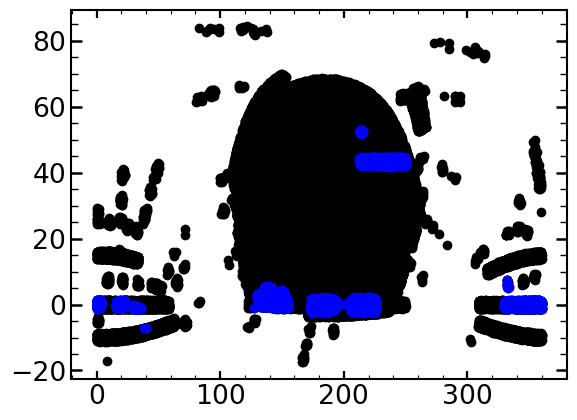

In [9]:
# check the overlap with SDSS
# import dr7 (at the start of section 1), if you skipped section 1

plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue')

In [10]:
# takes a bit less than 1 minute on my laptop
# this matches QSO from SDSS and resulting catalog from HSC
res_matching=[]
for j in tqdm(range(len(Positions_of_dr7))):
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],Positions_of_df)
    # shortest distance
    shortest_distance=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0]==np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res_matching.append([shortest_distance,df.loc[shortest_distance_index].values])

100%|██████████| 105645/105645 [00:41<00:00, 2548.22it/s]


In [18]:
# create array that has objects from SDSS that are found in HSC

matched_array=[]
matched_array_extended_SDSS=[]
for i in tqdm(range(len(res_matching))):
    if res_matching[i][0]>0.001:
        pass
    else:
        # extract columns 0,1,2,3,6,7,8,9,10,11 from SDSS, which are SDSS ID, ra, dec, redshift and psf measurments in different bands (g->[6,7],r->[8,9],i->[10,11])
        matched_array.append(np.concatenate((dr7.loc[i][[0,1,2,3,6,7,8,9,10,11]],res_matching[i][1])))
        # extract columns 1,2,3 which are ra, dec and redshift (plan to add mass from Schen catalog)
        matched_array_extended_SDSS.append(np.concatenate((dr7.loc[i][[1,2,3]],res_matching[i][1])))
        
matched_array=np.array(matched_array)
matched_array_extended_SDSS=np.array(matched_array_extended_SDSS)

100%|██████████| 105645/105645 [00:08<00:00, 12633.70it/s]


In [19]:
# filter out QSO which failed measurment, (g-band set at 0 in SDSS catlog)
matched_array_filtered=matched_array[matched_array[:,4]>16]
matched_array_extended_SDSS_filtered=matched_array_extended_SDSS[matched_array[:,4]>16]

(17, 25)

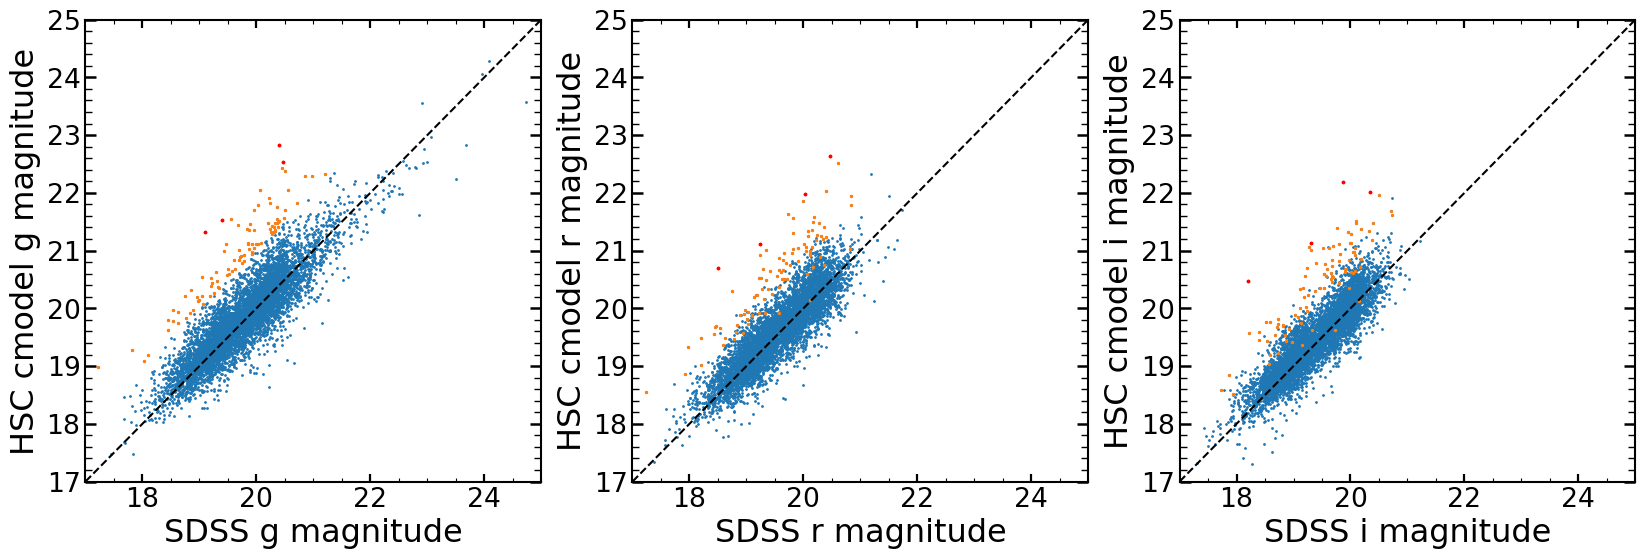

In [20]:
# plot differences using cmodel values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,8+4],s=1)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,8+4][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,8+4][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC cmodel g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,8+6],s=1)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,8+6][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,8+6][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC cmodel r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(133)

plt.scatter(matched_array_filtered[:,8],matched_array_filtered[:,8+8],s=1)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,8+8][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,8+8][(matched_array_filtered[:,8+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC cmodel i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

(17, 25)

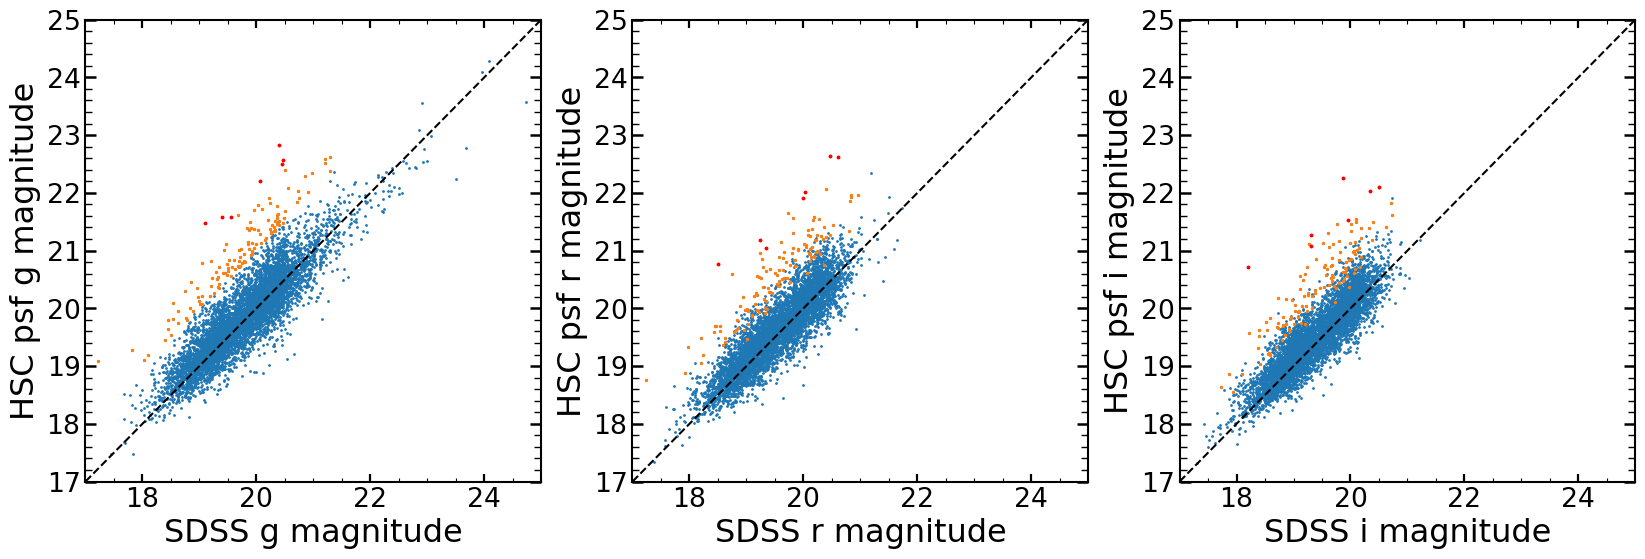

In [21]:
# plot differences using psf values from HSC
plt.figure(figsize=(20,6))
plt.subplot(131)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,14+4],s=1)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+4][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')

plt.xlabel('SDSS g magnitude')
plt.ylabel('HSC psf g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,14+6],s=1)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+6][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS r magnitude')
plt.ylabel('HSC psf r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)
plt.subplot(133)

plt.scatter(matched_array_filtered[:,8],matched_array_filtered[:,14+8],s=1)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],matched_array_filtered[:,14+8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1],s=2)
plt.scatter(matched_array_filtered[:,8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],matched_array_filtered[:,14+8][(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>2],s=3,color='red')
plt.xlabel('SDSS i magnitude')
plt.ylabel('HSC psf i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,25)
plt.ylim(17,25)

## Adding MacLeod catalogue

In [22]:
#########
#Can be skipped, just used for consistency check and to compare results
#########

#read in catalogue with pandas
MacLeod_Cat= np.loadtxt(DATA_DIRECTORY+'MacLeod2019_tab2.txt',dtype='str')

ra_dec_MacLeod_Cat_step1=[]
for i in range(len(MacLeod_Cat)):
    if '+' in MacLeod_Cat[:,0][i]:
        split_string=str.split(MacLeod_Cat[:,0][i],'+')
        split_string.insert(1,'+1')
        ra_dec_MacLeod_Cat_step1.append(split_string)
    else:
        split_string=str.split(MacLeod_Cat[:,0][i],'-')
        split_string.insert(1,'-1')
        ra_dec_MacLeod_Cat_step1.append(split_string)

ra_dec_MacLeod_Cat_step1=np.array(ra_dec_MacLeod_Cat_step1)

In [23]:
# split strings from MacLeod catalogue 
ra_dec_MacLeod_Cat_step2=[]
n=2
for i in range(len(ra_dec_MacLeod_Cat_step1)):
    ra_string=ra_dec_MacLeod_Cat_step1[i][0]
    dec_string=ra_dec_MacLeod_Cat_step1[i][2]
    ra_string_split=[ra_string[i:i+n] for i in range(0, len(ra_string), n)]
    dec_string_split=[dec_string[i:i+n] for i in range(0, len(dec_string), n)]
    ra_split=[float(ra_string_split[0]),float(ra_string_split[1]),float(ra_string_split[2]),float(ra_string_split[3]),float(ra_string_split[4])]
    dec_split=[float(ra_dec_MacLeod_Cat_step1[0][1])*float(dec_string_split[0]),float(dec_string_split[1]),float(dec_string_split[2]),float(dec_string_split[3])]
    ra_dec_MacLeod_Cat_step2.append([ra_split,dec_split])

In [24]:
# move in the same format as other catalogues
ra_dec_MacLeod_Cat_step3=[]
for i in range(len(ra_dec_MacLeod_Cat_step2)):
    ra_dec_MacLeod_Cat_step3.append([ra_dec_MacLeod_Cat_step2[i][0][0]*15+(ra_dec_MacLeod_Cat_step2[i][0][1]/60)*15+((ra_dec_MacLeod_Cat_step2[i][0][2]+ra_dec_MacLeod_Cat_step2[i][0][3])/3600)*15,
     ra_dec_MacLeod_Cat_step2[i][1][0]+(ra_dec_MacLeod_Cat_step2[i][1][1]/60)+(ra_dec_MacLeod_Cat_step2[i][1][2]/3600)])
    
ra_dec_MacLeod_Cat_step3=np.array(ra_dec_MacLeod_Cat_step3)

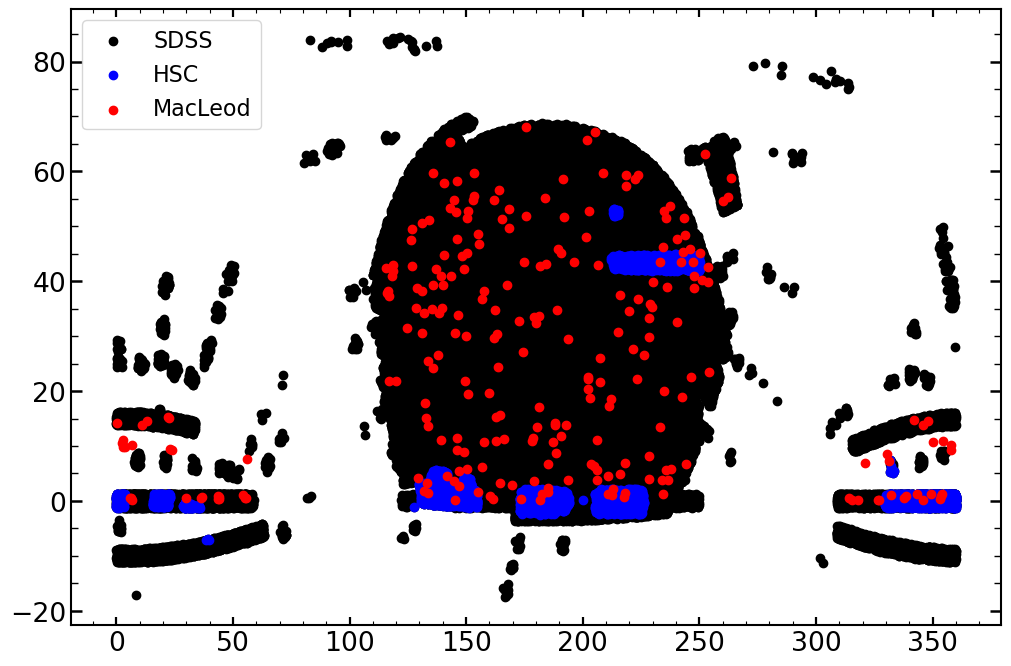

In [25]:
# check the overlap with SDSS
plt.figure(figsize=(12,8))
plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black',label='SDSS')
plt.scatter(Positions_of_df[:,0],Positions_of_df[:,1],color='blue',label='HSC')
plt.scatter(ra_dec_MacLeod_Cat_step3[:,0],ra_dec_MacLeod_Cat_step3[:,1],color='red',label='MacLeod')
plt.legend()

In [26]:
# again takes around a minute
res=[]
for j in tqdm(range(len(Positions_of_dr7))):
    
    #HSC catalogue search; same as above
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],Positions_of_df)
    # shortest distance
    shortest_distance_HSC=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index_HSC=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_HSC)[0][0]
    
    
    
    #MacLeod catalogue search; same as above
    # finds distance from each of the objects in dr7 catalogue from the objects in HSC catalogue
    PositionOfQuasars_euclidean_distances=euclidean_distances([Positions_of_dr7[j]],ra_dec_MacLeod_Cat_step3)
    # shortest distance
    shortest_distance_MacLeod=np.min(PositionOfQuasars_euclidean_distances[0])
    # element of the ``Positions_of_df'' that has the shortest distance to the SDSS QSO
    shortest_distance_index_MacLeod=np.where(PositionOfQuasars_euclidean_distances[0]==shortest_distance_MacLeod)[0][0]    
    
    res.append([shortest_distance_HSC,shortest_distance_MacLeod,df.loc[shortest_distance_index_HSC].values,MacLeod_Cat[shortest_distance_index_MacLeod]])

100%|██████████| 105645/105645 [01:00<00:00, 1760.14it/s]


In [27]:
# extract columns 0,1,2,3,6,7,8,9,10,11 from SDSS, which are as above: sdss id, ra, dec, z, and measurments in different bands (gri)
matched_array_MacLeod_SDSS=[]
not_matched_array_MacLeod_SDSS=[]
for i in tqdm(range(len(res))):
    # is object close to HSC 
    if res[i][0]>0.001:
        pass
    else:
        # if the objects is avaliabe in HSC, search for it in MacLeod
        if res[i][1]>0.001:
            pass
        else:
            # join the SDSSvalue, with the value from HSC and MacLeod
            matched_array_MacLeod_SDSS.append(np.concatenate((dr7.loc[i][[0,1,2,3,6,7,8,9,10,11]],res[i][2],res[i][3])))
        
matched_array_MacLeod_SDSS=np.array(matched_array_MacLeod_SDSS)

100%|██████████| 105645/105645 [00:00<00:00, 1473840.66it/s]


number of objects that have been found is: 11


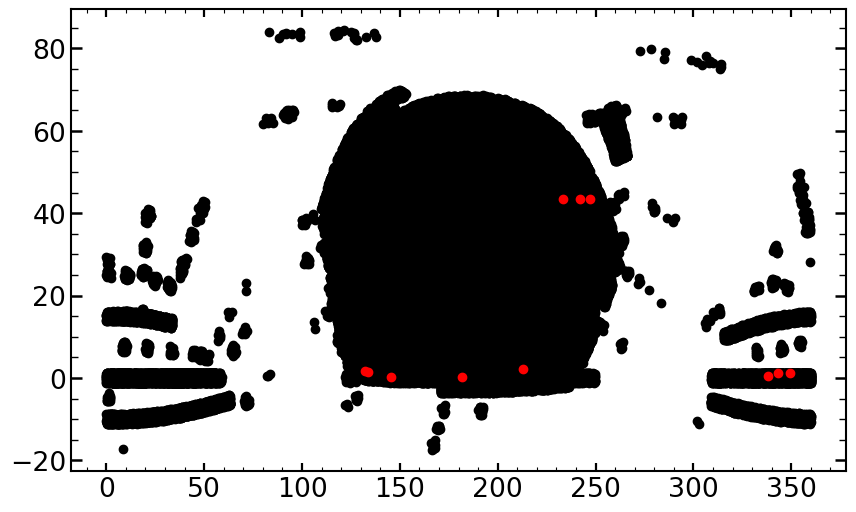

In [28]:
# check the overlap of the matched_array_MacLeod_SDSS wit the SDSS
print('number of objects that have been found is: '+str(len(matched_array_MacLeod_SDSS)))
plt.figure(figsize=(10,6))
plt.scatter(Positions_of_dr7[:,0],Positions_of_dr7[:,1],color='black')
plt.scatter(matched_array_MacLeod_SDSS[:,1],matched_array_MacLeod_SDSS[:,2],color='red')


In [ ]:
# columns of matched_array_MacLeod_SDSS
# 0. SDSS ID, 1. ra (SDSS), 2. dec (SDSS), 3. redshift (SDSS), 4. g-mag (SDSS) 5. sigma g-mag (SDSS), 6. r-mag (SDSS) 7. sigma r-mag (SDSS), 8. i-mag (SDSS) 9. sigma i-mag (SDSS)
# 10. ra (HSC), 11. dec (HSC), 12. g_cmodel_mag, 13. g_cmodel_magsigma, 14. r_cmodel_mag, 15. r_cmodel_magsigma, 16. i_cmodel_mag, 17. i_cmodel_magsigma,
# 18. g_psfflux_mag, 19. g_psfflux_magsigma, 20. r_psfflux_mag, 21. r_psfflux_magsigma, 22. i_psfflux_mag, 23. i_psfflux_magsigma, 24. object_id
# 25. SDSSJID, 26. z, 27. morph. flag (=0 for point source, 1 for extended), 28. Phot. MJD_1, 29. g_1 (mag), 30. sigma_1 (mag), 31. Phot. MJD_2
# 32. g_2 (mag), 33. sigma_2 (mag), 34. Spec. MJD_1, 35.  MJD (PS1), 36. g_PS1 (mag), 37. sigma_PS1 (mag), 38. Spec. MJD_2, 39. Facility , 
# 40. CLQ by VI?  (=1 for visual CLQ, 0 otherwise), 41. N_sigma (Hbeta) 

In [29]:
# Check that you selected correct objects by comparing SDSS and MacLeod catalogue
is_correctly_matched=[]
for i in range(len(matched_array_MacLeod_SDSS)):
    is_correctly_matched.append(matched_array_MacLeod_SDSS[i][0]==matched_array_MacLeod_SDSS[i][25])
    
# if result is 1, it is correct
print(np.mean(is_correctly_matched))

1.0


In [52]:
mag_selection=(matched_array_filtered[:,2]<10)&(matched_array_filtered[:,1]<16*15)&(matched_array_filtered[:,1]>10*15)

(17, 23)

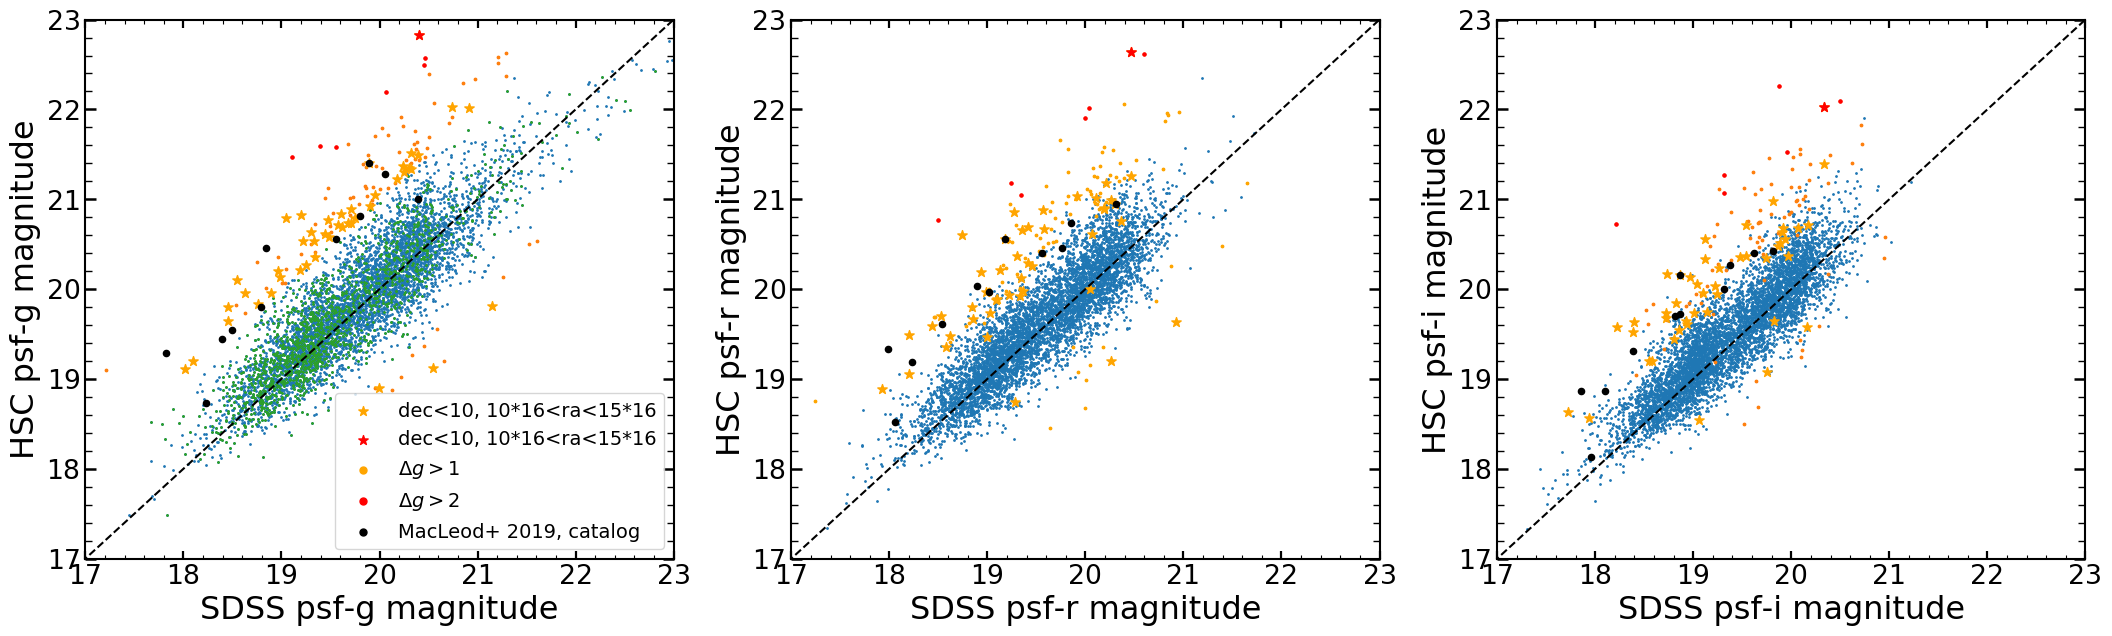

In [116]:
matplotlib.rcParams.update({'font.size': 16})

#showing the same plot, but now with the psf magnitudes
selection_of_objects_1_mag_dimmer=np.abs((matched_array_filtered[:,14+4]-matched_array_filtered[:,4]))>1
selection_of_objects_2_mag_dimmer=np.abs((matched_array_filtered[:,14+4]-matched_array_filtered[:,4]))>2

selection_of_objects_actual_1_mag_dimmer=(matched_array_filtered[:,14+4]-matched_array_filtered[:,4])>1
arrowup = u'$\u2191$'

# select object fainter than 23 mag in g-band today to represent with arrows on the plot
matched_array_filtered_and_more_than_2_mag_dimmer=matched_array_filtered[selection_of_objects_2_mag_dimmer]
matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now=matched_array_filtered_and_more_than_2_mag_dimmer[matched_array_filtered_and_more_than_2_mag_dimmer[:,8+4]>23]

matched_array_filtered_and_more_than_1_mag_dimmer=matched_array_filtered[selection_of_objects_1_mag_dimmer]
matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now=matched_array_filtered_and_more_than_1_mag_dimmer[matched_array_filtered_and_more_than_1_mag_dimmer[:,8+4]>23]


plt.figure(figsize=(20,7))
plt.subplot(131)

plt.subplots_adjust(left=-0.10)

plt.scatter(matched_array_filtered[:,4],matched_array_filtered[:,14+4],s=1)
plt.scatter(matched_array_filtered[:,4][selection_of_objects_1_mag_dimmer],
            matched_array_filtered[:,14+4][selection_of_objects_1_mag_dimmer],s=3)
plt.scatter(matched_array_filtered[:,4][selection_of_objects_2_mag_dimmer],
            matched_array_filtered[:,14+4][selection_of_objects_2_mag_dimmer],s=5,color='red')
# first plot those that are 1 mag dimmer and faint
plt.scatter(matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now[:,4],
            np.full(len(matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now),22.8),s=30,color='orange',marker=arrowup)
# and then those that are 2 mag dimmer and faint (which will overwrite correct orange objects)
plt.scatter(matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now[:,4],
            np.full(len(matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now),22.8),s=30,color='red',marker=arrowup)

plt.scatter(matched_array_filtered[mag_selection][:,4],matched_array_filtered[mag_selection][:,14+4],s=1,marker='*')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)][:,4],
            matched_array_filtered[np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)][:,14+4],s=50,marker='*',color='orange',label='dec<10, 10*16<ra<15*16')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,4],
            matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,14+4],s=50,marker='*',color='red',label='dec<10, 10*16<ra<15*16')

plt.scatter(matched_array_MacLeod_SDSS[:,4],matched_array_MacLeod_SDSS[:,18],s=20,color='black')

plt.scatter([], [], c='orange', s=25,label='$\Delta g>1$')
plt.scatter([], [], c='red',  s=25,label='$\Delta g>2$')
plt.scatter([], [], c='black', s=25,label='MacLeod+ 2019, catalog')
plt.legend(loc=4, fontsize=14)

plt.xlabel('SDSS psf-g magnitude')
plt.ylabel('HSC psf-g magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

plt.subplot(132)

plt.scatter(matched_array_filtered[:,6],matched_array_filtered[:,14+6],s=1)
plt.scatter(matched_array_filtered[:,6][selection_of_objects_1_mag_dimmer],matched_array_filtered[:,14+6][selection_of_objects_1_mag_dimmer],s=3,color='orange')
plt.scatter(matched_array_filtered[:,6][np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)],matched_array_filtered[:,14+6][np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)],s=50,color='orange',marker='*')
plt.scatter(matched_array_filtered[:,6][selection_of_objects_2_mag_dimmer],matched_array_filtered[:,14+6][selection_of_objects_2_mag_dimmer],s=5,color='red')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,6],
            matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,14+6],s=50,marker='*',color='red',label='dec<10, 10*16<ra<15*16')


plt.scatter(matched_array_MacLeod_SDSS[:,6],matched_array_MacLeod_SDSS[:,20],s=20,color='black')

plt.xlabel('SDSS psf-r magnitude')
plt.ylabel('HSC psf-r magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

plt.subplot(133)

plt.scatter(matched_array_filtered[:,8],matched_array_filtered[:,14+8],s=1)
plt.scatter(matched_array_filtered[:,8][selection_of_objects_1_mag_dimmer],matched_array_filtered[:,14+8][selection_of_objects_1_mag_dimmer],s=3)
plt.scatter(matched_array_filtered[:,8][np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)],matched_array_filtered[:,14+8][np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)],s=50,color='orange',marker='*')

plt.scatter(matched_array_filtered[:,8][selection_of_objects_2_mag_dimmer],matched_array_filtered[:,14+8][selection_of_objects_2_mag_dimmer],s=5,color='red')

plt.scatter(matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,8],
            matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,14+8],s=50,marker='*',color='red',label='dec<10, 10*16<ra<15*16')

plt.scatter(matched_array_MacLeod_SDSS[:,8],matched_array_MacLeod_SDSS[:,22],s=20,color='black')

plt.xlabel('SDSS psf-i magnitude')
plt.ylabel('HSC psf-i magnitude')
plt.plot(range(0,100),range(0,100),color='black',ls='--')
plt.xlim(17,23)
plt.ylim(17,23)

In [63]:
ra_Mag_selected=(matched_array_filtered[(matched_array_filtered[:,1]<10)&(matched_array_filtered[:,2]<24*15)&(matched_array_filtered[:,2]>0*15)])[:,1]
dec_Mag_selected=(matched_array_filtered[(matched_array_filtered[:,1]<10)&(matched_array_filtered[:,2]<24*15)&(matched_array_filtered[:,2]>0*15)])[:2]


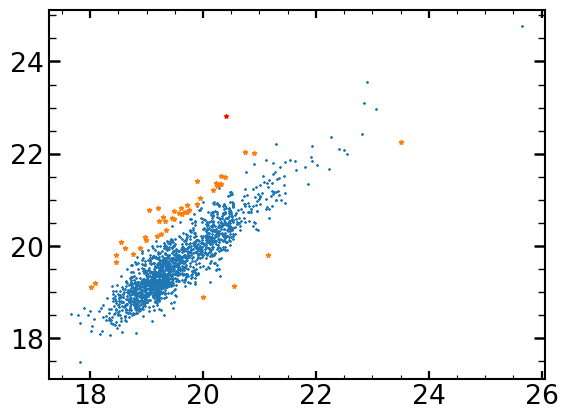

In [97]:
plt.scatter(matched_array_filtered[mag_selection][:,4],matched_array_filtered[mag_selection][:,14+4],s=1,marker='*')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)][:,4],
            matched_array_filtered[np.all((selection_of_objects_1_mag_dimmer,mag_selection),axis=0)][:,14+4],s=10,marker='*')
plt.scatter(matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,4],
            matched_array_filtered[np.all((selection_of_objects_2_mag_dimmer,mag_selection),axis=0)][:,14+4],s=5,color='red',marker='*')
# first plot those that are 1 mag dimmer and faint
#plt.scatter(matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now[:,4],
#            np.full(len(matched_array_filtered_and_more_than_1_mag_dimmer_and_faint_now),22.8),s=30,color='orange',marker=arrowup)
# and then those that are 2 mag dimmer and faint (which will overwrite correct orange objects)
#plt.scatter(matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now[:,4],
#            np.full(len(matched_array_filtered_and_more_than_2_mag_dimmer_and_faint_now),22.8),s=30,color='red',marker=arrowup)

# Combining both c-model and psf magnitudes and output

In [88]:
# sdss psf-g band mag - HSC psf-g band mag
g_mag_dif=(matched_array_filtered[:,4]-matched_array_filtered[:,14+4]).astype(float)
# error sdss g band mag - HSC g band mag
g_mag_dif_err=np.sqrt(((matched_array_filtered[:,5]).astype(float))**2+((matched_array_filtered[:,14+5]).astype(float))**2)

In [89]:
# insert differences in the catalog
matched_array_filtered_with_g_mag_dif=np.insert(matched_array_filtered, 4, g_mag_dif, axis=1)
matched_array_filtered_with_g_mag_dif_and_err=np.insert(matched_array_filtered_with_g_mag_dif, 5, g_mag_dif_err, axis=1)

In [90]:
# extra step to get nice looking output when exported to .txt
data = np.zeros((len(matched_array_filtered_with_g_mag_dif_and_err)), dtype={'names':['SDSS ID','ra (SDSS)', 'dec (SDSS)', 'redshift', 'Delta g-band','Delta g-band err', 'g-band (SDSS)', 'g-band err (SDSS)',
                                                                                   'r-band (SDSS)','r-band err (SDSS)','i-band (SDSS)','i-band err (SDSS)','ra (HSC)', 'dec (HSC)',
                                                                                   'g_cmodel_mag (HSC)','g_cmodel_magsigma (HSC)','r_cmodel_mag (HSC)','r_cmodel_magsigma (HSC)',
                                                                                   'i_cmodel_mag (HSC)','i_cmodel_magsigma (HSC)','g_psfflux_mag (HSC)','g_psfflux_magsigma (HSC)',
                                                                                  'r_psfflux_mag (HSC)','r_psfflux_magsigma (HSC)','i_psfflux_mag (HSC)', 'i_psfflux_magsigma (HSC)',
                                                                                   'object_id (HSC)'],
                          'formats':['U18','f2', 'f4','f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','f4', 'f4', 'f4','i8']})

In [91]:
for i in range(matched_array_filtered_with_g_mag_dif_and_err.shape[1]):
    data[data.dtype.names[i]]=matched_array_filtered_with_g_mag_dif_and_err[:,i]

In [92]:
np.savetxt("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/matched_array_filtered_with_g_mag_dif_and_err_Feb_16.csv", data, delimiter=",", 
           header="#List of SDSS AGN from DR7 that are found in HSC survey, with their magnitudes \n#created on Feb 16, 2019\n#code at https://github.com/nevencaplar/Variability/tree/master/HSC \n#@Neven Caplar, Princeton University \n#ncaplar@princeton.edu\n# \n#SDSS ID \n#ra (SDSS) \n#dec (SDSS) \n#redshift \n#Delta g-band (g-band psf SDSS magnitude - g_psfflux_mag (HSC))  \n#Delta g-band err (sqrt(g-band psf err (SDSS)**2+g_psfflux_magsigma (HSC)**2)) \n#g-band (SDSS - all SDSS magnitudes are psf magnitudes) \n#g-band err (SDSS)  \n#r-band (SDSS)  \n#r-band err (SDSS) \n#i-band (SDSS) \n#i-band err (SDSS)  \n#ra (HSC)  \n#dec (HSC)  \n#g_cmodel_mag (HSC)  \n#g_cmodel_magsigma (HSC)  \n#r_cmodel_mag (HSC)  \n#r_cmodel_magsigma (HSC)  \n#i_cmodel_mag (HSC) \n# i_cmodel_magsigma (HSC)  \n#g_psfflux_mag (HSC)  \n# g_psfflux_magsigma (HSC) \n#r_psfflux_mag (HSC) \n#r_psfflux_magsigma (HSC) \n#i_psfflux_mag (HSC) \n#i_psfflux_magsigma (HSC) \n#object_id (HSC) \n  ", comments='',fmt='%s')

# Creating selection for Spectro follow up

In [114]:
data_selected=data[np.all((selection_of_objects_actual_1_mag_dimmer,mag_selection),axis=0)]
data_selected_cleaned=np.delete(data_selected,11)

In [105]:
SDSS_name_MacLeod=[]
for i in range(len(matched_array_MacLeod_SDSS)):
    SDSS_name_MacLeod.append(matched_array_MacLeod_SDSS[i][0])

In [106]:
SDSS_name_MacLeod

['084820.15+014620.3',
 '085451.72+012609.9',
 '094132.89+000731.1',
 '120710.25+000806.1',
 '141213.61+021202.1',
 '153240.87+433225.2',
 '160742.94+432816.4',
 '162829.18+432948.5',
 '223133.89+003312.7',
 '225240.37+010958.7',
 '231742.68+011425.2']

In [143]:
data_selected_cleaned_priority_1

array([('113416.81-001902.3', 173.6, -0.317331, 0.3558, -1.2890283, 0.02404007, 19.479, 0.024, 19.001, 0.015, 18.799, 0.02 , 173.57004, -0.3173373 , 20.249916, 0.00125634, 19.085238, 0.00070483, 18.67237 , 0.00131704, 20.768028, 0.00138739, 19.461918, 0.00073584, 19.446054, 0.00154269, 41091386639939128),
       ('120357.26+011630.6', 181. ,  1.275191, 1.1496, -1.3507603, 0.03601444, 18.45 , 0.036, 18.197, 0.016, 18.224, 0.017, 180.9886 ,  1.2752061 , 19.79802 , 0.00103065, 19.479452, 0.00087557, 19.574669, 0.00085808, 19.80076 , 0.00101976, 19.49091 , 0.00087355, 19.577682, 0.00085215, 42182106469657952),
       ('121658.95+001153.7', 184.2,  0.198259, 1.1799, -1.3325123, 0.01809935, 19.298, 0.018, 19.128, 0.02 , 19.115, 0.024, 184.24565,  0.19827634, 20.628063, 0.0019616 , 20.202866, 0.0014432 , 20.33236 , 0.00110793, 20.630512, 0.00189376, 20.209553, 0.0014252 , 20.334671, 0.00110022, 42190601914969912),
       ('122638.66-001114.0', 186.6, -0.187247, 0.6427, -1.5534661, 0.0170373 ,

In [144]:
data_selected_cleaned_priority_1=data_selected_cleaned[data_selected_cleaned['Delta g-band']<-1.25]
data_selected_cleaned_priority_1

array([('113416.81-001902.3', 173.6, -0.317331, 0.3558, -1.2890283, 0.02404007, 19.479, 0.024, 19.001, 0.015, 18.799, 0.02 , 173.57004, -0.3173373 , 20.249916, 0.00125634, 19.085238, 0.00070483, 18.67237 , 0.00131704, 20.768028, 0.00138739, 19.461918, 0.00073584, 19.446054, 0.00154269, 41091386639939128),
       ('120357.26+011630.6', 181. ,  1.275191, 1.1496, -1.3507603, 0.03601444, 18.45 , 0.036, 18.197, 0.016, 18.224, 0.017, 180.9886 ,  1.2752061 , 19.79802 , 0.00103065, 19.479452, 0.00087557, 19.574669, 0.00085808, 19.80076 , 0.00101976, 19.49091 , 0.00087355, 19.577682, 0.00085215, 42182106469657952),
       ('121658.95+001153.7', 184.2,  0.198259, 1.1799, -1.3325123, 0.01809935, 19.298, 0.018, 19.128, 0.02 , 19.115, 0.024, 184.24565,  0.19827634, 20.628063, 0.0019616 , 20.202866, 0.0014432 , 20.33236 , 0.00110793, 20.630512, 0.00189376, 20.209553, 0.0014252 , 20.334671, 0.00110022, 42190601914969912),
       ('122638.66-001114.0', 186.6, -0.187247, 0.6427, -1.5534661, 0.0170373 ,

In [145]:
data_selected_cleaned_priority_2=data_selected_cleaned[data_selected_cleaned['Delta g-band']>-1.25]

In [148]:
np.savetxt("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/data_selected_cleaned_priority_1.csv", data_selected_cleaned_priority_1, delimiter=",", 
           header="#List of SDSS AGN from DR7 that are found in HSC survey, with their magnitudes \n#Difference between HSC and SDSS larger than 1 mag \n#Within Magellan footprint \n#created on Mar 22, 2019\n#code at https://github.com/nevencaplar/Variability/tree/master/HSC \n#@Neven Caplar, Princeton University \n#ncaplar@princeton.edu\n# \n#SDSS ID \n#dec (SDSS) \n#ra (SDSS) \n#redshift \n#Delta g-band (g-band psf SDSS magnitude - g_psfflux_mag (HSC))  \n#Delta g-band err (sqrt(g-band psf err (SDSS)**2+g_psfflux_magsigma (HSC)**2)) \n#g-band (SDSS - all SDSS magnitudes are psf magnitudes) \n#g-band err (SDSS)  \n#r-band (SDSS)  \n#r-band err (SDSS) \n#i-band (SDSS) \n#i-band err (SDSS)  \n#ra (HSC)  \n#dec (HSC)  \n#g_cmodel_mag (HSC)  \n#g_cmodel_magsigma (HSC)  \n#r_cmodel_mag (HSC)  \n#r_cmodel_magsigma (HSC)  \n#i_cmodel_mag (HSC) \n# i_cmodel_magsigma (HSC)  \n#g_psfflux_mag (HSC)  \n# g_psfflux_magsigma (HSC) \n#r_psfflux_mag (HSC) \n#r_psfflux_magsigma (HSC) \n#i_psfflux_mag (HSC) \n#i_psfflux_magsigma (HSC) \n#object_id (HSC) \n  ", comments='',fmt='%s')

In [149]:
np.savetxt("/Users/nevencaplar/Documents/Variability/Github/Variability/HSC/data_selected_cleaned_priority_2.csv", data_selected_cleaned_priority_2, delimiter=",", 
           header="#List of SDSS AGN from DR7 that are found in HSC survey, with their magnitudes \n#Difference between HSC and SDSS larger than 1 mag \n#Within Magellan footprint \n#created on Mar 22, 2019\n#code at https://github.com/nevencaplar/Variability/tree/master/HSC \n#@Neven Caplar, Princeton University \n#ncaplar@princeton.edu\n# \n#SDSS ID \n#dec (SDSS) \n#ra (SDSS) \n#redshift \n#Delta g-band (g-band psf SDSS magnitude - g_psfflux_mag (HSC))  \n#Delta g-band err (sqrt(g-band psf err (SDSS)**2+g_psfflux_magsigma (HSC)**2)) \n#g-band (SDSS - all SDSS magnitudes are psf magnitudes) \n#g-band err (SDSS)  \n#r-band (SDSS)  \n#r-band err (SDSS) \n#i-band (SDSS) \n#i-band err (SDSS)  \n#ra (HSC)  \n#dec (HSC)  \n#g_cmodel_mag (HSC)  \n#g_cmodel_magsigma (HSC)  \n#r_cmodel_mag (HSC)  \n#r_cmodel_magsigma (HSC)  \n#i_cmodel_mag (HSC) \n# i_cmodel_magsigma (HSC)  \n#g_psfflux_mag (HSC)  \n# g_psfflux_magsigma (HSC) \n#r_psfflux_mag (HSC) \n#r_psfflux_magsigma (HSC) \n#i_psfflux_mag (HSC) \n#i_psfflux_magsigma (HSC) \n#object_id (HSC) \n  ", comments='',fmt='%s')

# Small investigation of the properties of sources selected as variable


## redshift

In [49]:
delta_g_and_redshift=matched_array_filtered_with_g_mag_dif_and_err[:,[4,3]]

In [50]:
delta_g_and_redshift_sorted_by_delta_g_and_split=np.array_split(delta_g_and_redshift[np.argsort(delta_g_and_redshift[:,0])],int(len(delta_g_and_redshift)/10))

delta_g_and_redshift_sorted_by_redshift_g_and_split=np.array_split(delta_g_and_redshift[np.argsort(delta_g_and_redshift[:,1])],int(len(delta_g_and_redshift)/10))

In [51]:
res_delta_redshift_via_delta=[]
res_delta_redshift_via_delta_median=[]
for i in range(len(delta_g_and_redshift_sorted_and_split)):
    res_delta_redshift_via_delta.append(np.mean(delta_g_and_redshift_sorted_by_delta_g_and_split[i],axis=0))
    res_delta_redshift_via_delta_median.append(np.median(delta_g_and_redshift_sorted_by_delta_g_and_split[i],axis=0))
    
res_delta_redshift_via_delta=np.array(res_delta_redshift_via_delta)
res_delta_redshift_via_delta_median=np.array(res_delta_redshift_via_delta_median)

res_delta_redshift_via_redshift=[]
res_delta_redshift_via_redshift_median=[]
for i in range(len(delta_g_and_redshift_sorted_and_split)):
    res_delta_redshift_via_redshift.append(np.mean(delta_g_and_redshift_sorted_by_redshift_g_and_split[i],axis=0))
    res_delta_redshift_via_redshift_median.append(np.median(delta_g_and_redshift_sorted_by_redshift_g_and_split[i],axis=0))
    
res_delta_redshift_via_redshift=np.array(res_delta_redshift_via_redshift)
res_delta_redshift_via_redshift_median=np.array(res_delta_redshift_via_redshift_median)

NameError: name 'delta_g_and_redshift_sorted_and_split' is not defined

In [238]:
p20=np.poly1d(np.polyfit(res_delta_redshift_via_redshift[:,1].astype(float),res_delta_redshift_via_redshift[:,0].astype(float),2))

Text(0.5,0,'redshift')

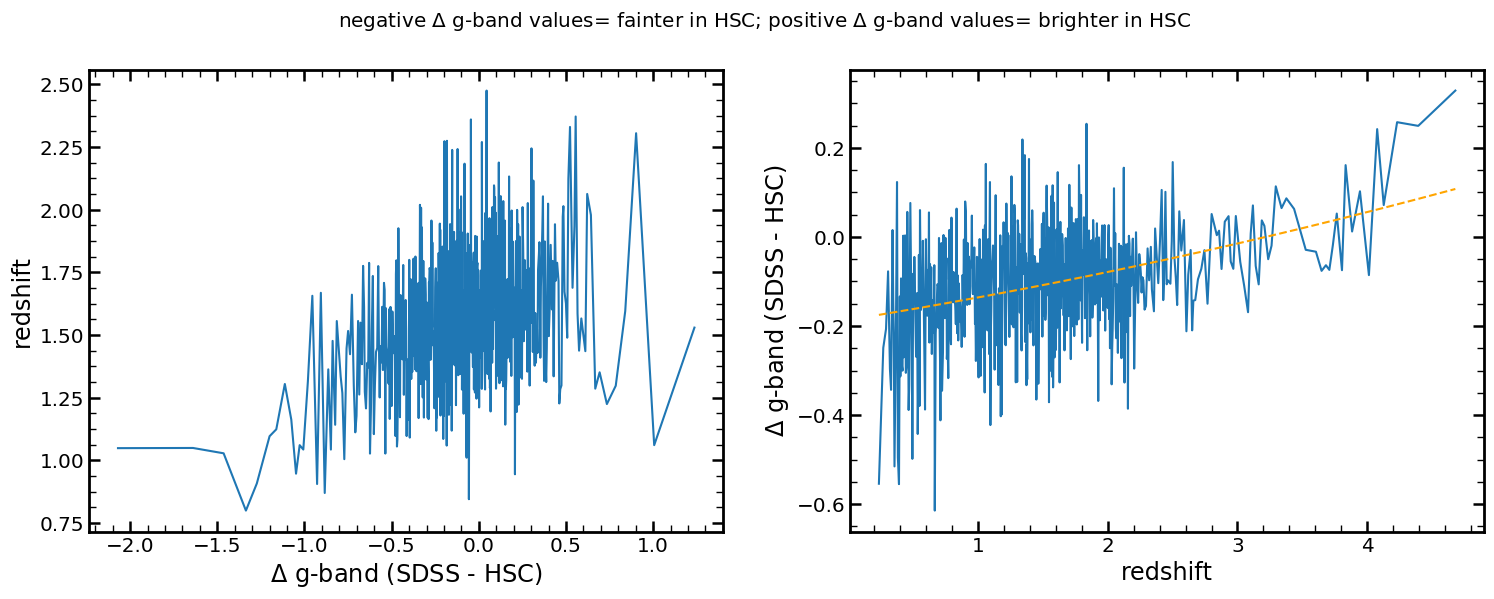

In [361]:
# below we are seeing, most probably, difference between SDSS and HSC filters 
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.suptitle('negative $\Delta$ g-band values= fainter in HSC; positive $\Delta$ g-band values= brighter in HSC')
plt.plot(res_delta_redshift_via_delta[:,0],res_delta_redshift_via_delta[:,1])
#plt.plot(res_delta_redshift_via_delta_median[:,0],res_delta_redshift_via_delta_median[:,1],alpha=0.2)
plt.xlabel('$\Delta$ g-band (SDSS - HSC)')
plt.ylabel('redshift')
plt.subplot(122)
plt.plot(res_delta_redshift_via_redshift[:,1],res_delta_redshift_via_redshift[:,0])
plt.plot(res_delta_redshift_via_redshift[:,1],p20(res_delta_redshift_via_redshift[:,1].astype(float)),ls='--',color='orange')
#plt.plot(res_delta_redshift_via_redshift_median[:,1],res_delta_redshift_via_redshift_median[:,0],alpha=0.2)
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')

In [241]:
from astropy.io import fits

dr7_bh=fits.open('/Users/nevencaplar/Documents/Variability/HSC_Data/dr7_bh_May09_2011.fits')

In [270]:
# extract information from the fits file (SDSS ID, ra, dec, redshift, bolometric luminosity, Mass)
dr7_bh_extracted=[]
for j in tqdm(range(len(dr7_bh[1].data))):
    single_line=[]
    for i in [0,1,2,3,11,138]:
        single_line.append(dr7_bh[1].data[j][i])
    dr7_bh_extracted.append(single_line)
    
dr7_bh_extracted=np.array(dr7_bh_extracted)

In [292]:
# order in the same way as the data
dr7_bh_extracted_matched_to_data=[]
for i in tqdm(range(len(data))):
    dr7_bh_extracted_matched_to_data.append(dr7_bh_extracted[dr7_bh_extracted[:,0]==data[i][0]][0])
    
dr7_bh_extracted_matched_to_data=np.array(dr7_bh_extracted_matched_to_data)

100%|██████████| 5919/5919 [00:26<00:00, 220.12it/s]


In [365]:
matched_array_filtered_with_g_mag_dif_and_err[:,4]-p20(dr7_bh_extracted_matched_to_data[:,3].astype(float))

array([0.26797420413577044, 0.26220421032287294, 0.16277514307579696, ...,
       -0.16800620015029483, 0.14655053023271447, 0.0936355145665204],
      dtype=object)

In [366]:
red_lum_mass_dif=np.transpose(np.array([dr7_bh_extracted_matched_to_data[:,3].astype(float),dr7_bh_extracted_matched_to_data[:,4].astype(float),dr7_bh_extracted_matched_to_data[:,5].astype(float),
                                        matched_array_filtered_with_g_mag_dif_and_err[:,4],matched_array_filtered_with_g_mag_dif_and_err[:,4]-p20(dr7_bh_extracted_matched_to_data[:,3].astype(float))]))
red_lum_mass_dif=red_lum_mass_dif[red_lum_mass_dif[:,1]>44]
red_lum_mass_dif=red_lum_mass_dif[red_lum_mass_dif[:,2]>7]

In [369]:
red_lum_mass_dif

array([[1.8245999813079834, 46.03577387405987, 9.284316226710514,
        0.17874669999999782, 0.26797420413577044],
       [1.8372999429702759, 46.3763261532616, 9.169479508191511,
        0.17373149999999882, 0.26220421032287294],
       [1.4364999532699585, 45.804670154931976, 8.59142526568717,
        0.05100580000000576, 0.16277514307579696],
       ...,
       [1.7718000411987305, 46.654911646273966, 9.223171200693626,
        -0.26036009999999976, -0.16800620015029483],
       [1.6936999559402466, 46.281543502311074, 9.26727179183075,
        0.04960660000000061, 0.14655053023271447],
       [1.354200005531311, 45.77310053221589, 8.72512604783979,
        -0.022783600000000348, 0.0936355145665204]], dtype=object)

In [399]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def find_min(arr):
    res=[]
    for i in range(len(arr)):
        res.append(np.mean(arr[i],axis=0))
        
    return res

array_stack=red_lum_mass_dif[:,[1,2,4]]
# split size 1 determined so that each bin has 100 measurments
split_size_1=int(np.round(array_stack.shape[0]/200)   )
print(split_size_1)
# sort by first parameter
array_stack_sorted_by_0=array_stack[np.argsort(array_stack[:, 0])]
# split in split_size_1 arrays with same number of objects
array_stack_sorted_by_0_split=np.array(list(split(array_stack_sorted_by_0,split_size_1)))
res=[]
# when doing finer split, each bin will have around 10 objects
split_size_2=10 
for j in range(len(array_stack_sorted_by_0_split)):
    # within these arrays do one more split
    array_stack_sorted_by_0_split_sorted_by_1_split=np.array(list(split(array_stack_sorted_by_0_split[j][np.argsort(array_stack_sorted_by_0_split[j][:, 1])],split_size_2)))
    # find best value
    res.append(find_min(array_stack_sorted_by_0_split_sorted_by_1_split))


# get everthing in one array

res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))

29


Text(0,0.5,'Log(Mass/$M_{Sun}$)')

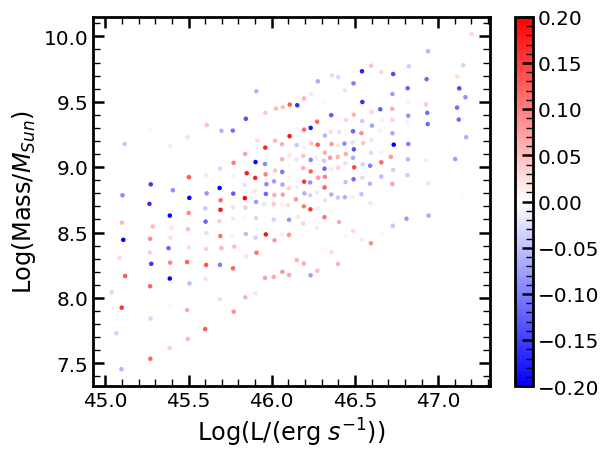

In [409]:
surf = plt.scatter(res[:,0].astype(float),res[:,1].astype(float),c=res[:,2],s=5,vmax=0.2,vmin=-0.2,cmap='bwr')
plt.colorbar()
plt.xlabel('Log(L/(erg $s^{-1}$))')
plt.ylabel('Log(Mass/$M_{Sun}$)')

Text(0,0.5,'$\\Delta$ g-band (SDSS - HSC)')

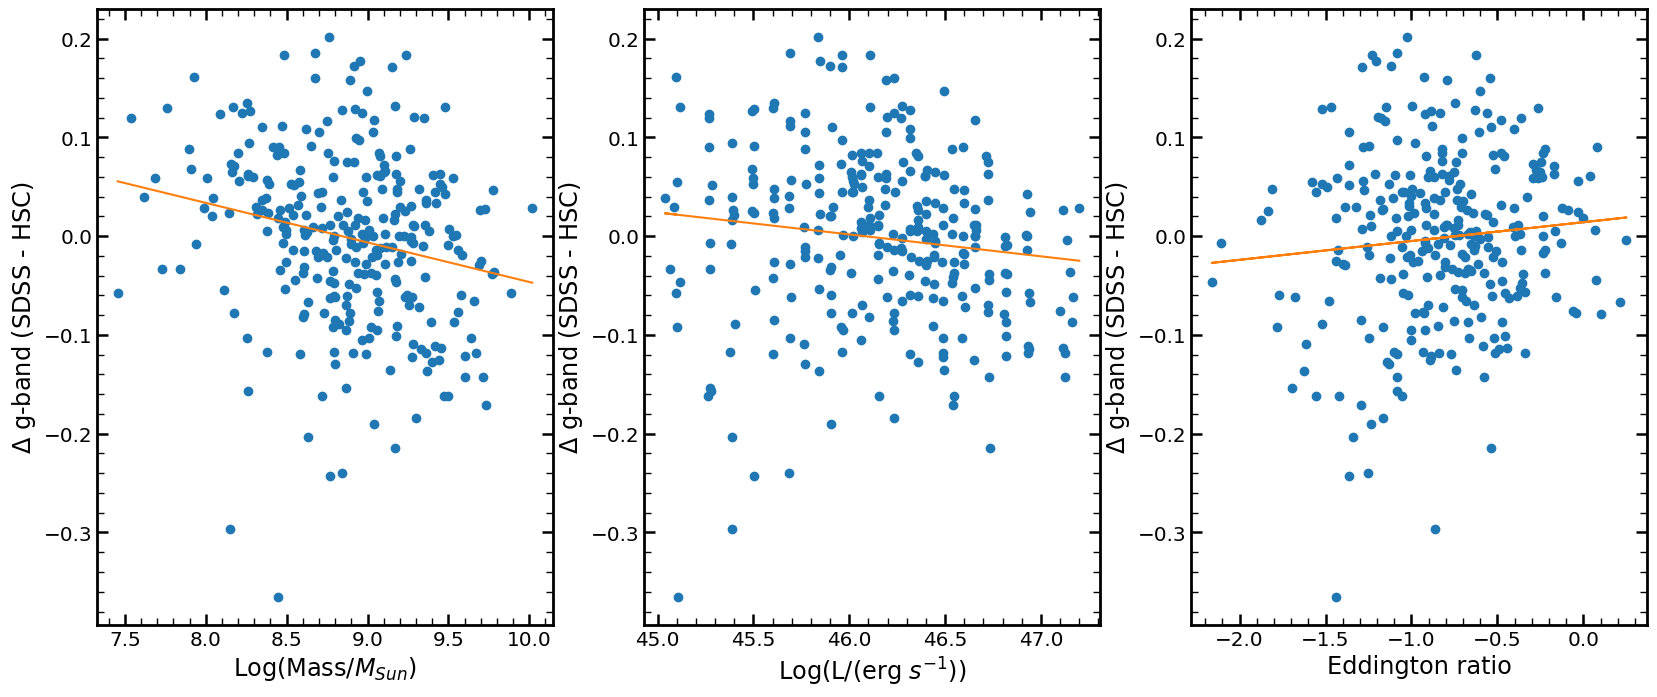

In [428]:
plt.figure(figsize=(20,8))

plt.subplot(131)
p1=np.polyfit(res[:,1].astype(float),res[:,2].astype(float),1)
p11= np.poly1d(p1)
plt.plot(res[:,1],res[:,2],ls='',marker='o')
plt.plot(res[:,1],p11(res[:,1]))
plt.xlabel('Log(Mass/$M_{Sun}$)')
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')

plt.subplot(132)

p1=np.polyfit(res[:,0].astype(float),res[:,2].astype(float),1)
p11= np.poly1d(p1)
plt.plot(res[:,0],res[:,2],ls='',marker='o')
plt.plot(res[:,0],p11(res[:,0]))
plt.xlabel('Log(L/(erg $s^{-1}$))')
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')

plt.subplot(133)

p1=np.polyfit((res[:,0]-res[:,1]-38.1).astype(float),res[:,2].astype(float),1)
p11= np.poly1d(p1)
plt.plot(res[:,0]-res[:,1]-38.1,res[:,2],ls='',marker='o')
plt.plot(res[:,0]-res[:,1]-38.1,p11(res[:,0]-res[:,1]-38.1))
plt.xlabel('Eddington ratio')
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')

Text(0,0.5,'$\\Delta$ g-band (SDSS - HSC)')

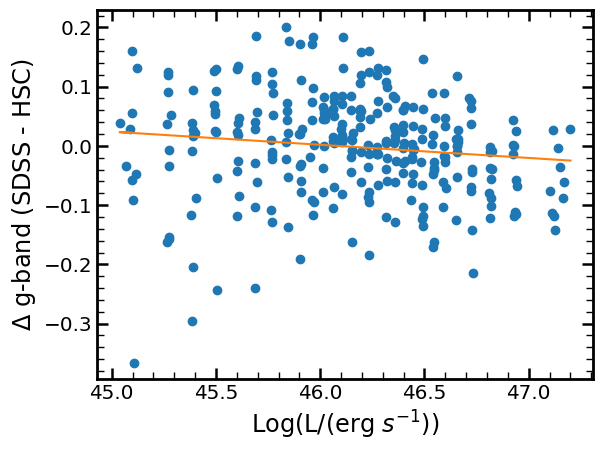

In [408]:
p1=np.polyfit(res[:,0].astype(float),res[:,2].astype(float),1)
p11= np.poly1d(p1)
plt.plot(res[:,0],res[:,2],ls='',marker='o')
plt.plot(res[:,0],p11(res[:,0]))
plt.xlabel('Log(L/(erg $s^{-1}$))')
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')